# 라이브러리, 데이터 불러오기

In [1]:
# 드라이브 연결
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 라이브러리 불러오기
import lightgbm as lgb
import pandas as pd

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
# 데이터 불러오기
path='/content/drive/MyDrive/BOAZ/물류 유통량 예측 경진대회/'
data = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
sample = pd.read_csv(path+'sample_submission.csv')

In [4]:
sample = pd.read_csv(path+'sample_submission.csv')

In [5]:
sample

,index,운송장_건수
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
7915,7915,0
7916,7916,0
7917,7917,0
7918,7918,0


In [6]:
data

,index,송하인_격자공간고유번호,수하인_격자공간고유번호,물품_카테고리,운송장_건수
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3
...,...,...,...,...,...
31679,31679,4471000290087200,5011000213073200,스포츠잡화,3
31680,31680,1129000014045300,5011000319087100,스마트디바이스,4
31681,31681,1129000014045300,5011000263065200,스마트디바이스,6
31682,31682,4127300065073100,5011000264061200,지갑,7


In [7]:
# 데이터 정보확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31684 entries, 0 to 31683
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         31684 non-null  int64 
 1   송하인_격자공간고유번호  31684 non-null  int64 
 2   수하인_격자공간고유번호  31684 non-null  int64 
 3   물품_카테고리       31684 non-null  object
 4   운송장_건수        31684 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.2+ MB


# 데이터 전처리

## 1) 칼럼명 변경

대회 데이터가 재가공되었기 때문에 칼럼명을 변경해준다.

In [8]:
# 킬럼명 변경
data.rename(columns={'송하인_격자공간고유번호' : 'SEND_SPG_INNB',
                        '수하인_격자공간고유번호' : 'REC_SPG_INNB',
                        '물품_카테고리' : 'DL_GD_MCLS_NM',
                        '운송장_건수' : 'INVC_CONT'}, inplace=True)

data

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_MCLS_NM,INVC_CONT
0,0,5011000595017300,2871000192069300,음반,3
1,1,4148000690043300,5011000264024400,문화컨텐츠,3
2,2,5011000078068400,1120000007005400,농산물,3
3,3,4127100048006400,5011000587019400,기타식품,7
4,4,5011000078068400,2823700010076300,농산물,3
...,...,...,...,...,...
31679,31679,4471000290087200,5011000213073200,스포츠잡화,3
31680,31680,1129000014045300,5011000319087100,스마트디바이스,4
31681,31681,1129000014045300,5011000263065200,스마트디바이스,6
31682,31682,4127300065073100,5011000264061200,지갑,7


In [9]:
test.rename(columns={'송하인_격자공간고유번호' : 'SEND_SPG_INNB',
                        '수하인_격자공간고유번호' : 'REC_SPG_INNB',
                        '물품_카테고리' : 'DL_GD_MCLS_NM'}, inplace=True)

test

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_MCLS_NM
0,0,4167000577042200,5011000435014100,선케어
1,1,1156000009012200,5011000172034400,구강위생용품
2,2,4122000363057300,5011000361097300,캠핑
3,3,5011000436041400,2826000084036400,아웃도어가구
4,4,4150000241065200,5011000169044300,분유/이유식/아기간식
...,...,...,...,...
7915,7915,5011000266051200,4623000417038100,농산물
7916,7916,1154500001098300,5011000264055100,문화컨텐츠
7917,7917,5013000610049100,1147000018091400,농산물
7918,7918,5013000610049100,3117000039026100,농산물


## 2) 격자공간고유변호 칼럼 가공

국토연구원 데이터 ( https://www.bigdata-region.kr/#/dataset/0ad3c882-f7ee-4faf-970d-00c53cb65a84) 를 참고해서 격자공간고유번호 칼럼을 가공해였다.

---

**<상세 내용>**


격자공간고유번호의 1~5자리: 시군구

격자공간고유번호의 1~10자리: 격자공간명

격자공간고유번호의 1~2자리: 지역 

을 나타낸다.

<br>

**이중 '시군구' (1~5자리) 기준으로 격자공간고유번호 칼럼을 가공하였다.**

In [10]:
# 격자공간고유번호 칼럼 가공
data['round_send']=data['SEND_SPG_INNB'].round(-10)
data['round_rec']=data['REC_SPG_INNB'].round(-10)
data

,index,SEND_SPG_INNB,REC_SPG_INNB,DL_GD_MCLS_NM,INVC_CONT,round_send,round_rec
0,0,5011000595017300,2871000192069300,음반,3,5011000000000000,2871000000000000
1,1,4148000690043300,5011000264024400,문화컨텐츠,3,4148000000000000,5011000000000000
2,2,5011000078068400,1120000007005400,농산물,3,5011000000000000,1120000000000000
3,3,4127100048006400,5011000587019400,기타식품,7,4127100000000000,5011000000000000
4,4,5011000078068400,2823700010076300,농산물,3,5011000000000000,2823700000000000
...,...,...,...,...,...,...,...
31679,31679,4471000290087200,5011000213073200,스포츠잡화,3,4471000000000000,5011000000000000
31680,31680,1129000014045300,5011000319087100,스마트디바이스,4,1129000000000000,5011000000000000
31681,31681,1129000014045300,5011000263065200,스마트디바이스,6,1129000000000000,5011000000000000
31682,31682,4127300065073100,5011000264061200,지갑,7,4127300000000000,5011000000000000


In [11]:
# 시군구 기준 주소정보 확인
a=list(set(data.round_send.to_list())) # 송하인 
b=list(set(data.round_rec.to_list())) # 수하인
sums=list(set(a+b))
print("송하인 주소 (시군구) 는 ", len(a), "개이고 \n수하인 주소 (시군구) 는 ", len(b), "개이고 \n송,수하인 주소 (시군구) 합은", len(sums),"개이다.")

송하인 주소 (시군구) 는  237 개이고 
수하인 주소 (시군구) 는  251 개이고 
송,수하인 주소 (시군구) 합은 251 개이다.


결론적으로 주소가 31864개 (원본, 격자공간 기준) => 251개 (가공, 시군구 기준) 로 변경되었다.

## 3) featrue one-hot encoding

In [12]:
# 딕셔너리 생성 (송하인, 수하인 통합)
nn=[]
for _ in range(len(sums)):
    n=[sums[_],_]
    nn.append(n)

nn=dict(nn)
nn

{1111000000000000: 202,
 1114000000000000: 121,
 1117000000000000: 20,
 1120000000000000: 10,
 1121500000000000: 88,
 1123000000000000: 97,
 1126000000000000: 14,
 1129000000000000: 173,
 1130500000000000: 151,
 1132000000000000: 77,
 1135000000000000: 181,
 1138000000000000: 161,
 1141000000000000: 57,
 1144000000000000: 243,
 1147000000000000: 142,
 1150000000000000: 52,
 1153000000000000: 228,
 1154500000000000: 176,
 1156000000000000: 129,
 1159000000000000: 190,
 1162000000000000: 211,
 1165000000000000: 111,
 1168000000000000: 30,
 1171000000000000: 196,
 1174000000000000: 119,
 2611000000000000: 184,
 2614000000000000: 166,
 2617000000000000: 72,
 2620000000000000: 249,
 2623000000000000: 93,
 2626000000000000: 115,
 2629000000000000: 238,
 2632000000000000: 138,
 2635000000000000: 47,
 2638000000000000: 216,
 2641000000000000: 124,
 2644000000000000: 35,
 2647000000000000: 201,
 2650000000000000: 108,
 2653000000000000: 21,
 2671000000000000: 44,
 2711000000000000: 69,
 2714000

앞서 언급한 것과 같이 주소 (송하인 + 수하인) 251개로 변경되었고 (시군구 시준) 

모든 수하인 주소는 송하인 주소에 포함된다는 것이 확인되었다.

In [13]:
# feature one-hot encoding
from tqdm import tqdm
for _ in tqdm(range(31684)): # 총 데이터 수
    data.loc[_,'send_dict']=str(nn[data['round_send'][_]])
    data.loc[_,'rec_dict']=str(nn[data['round_rec'][_]])

100%|██████████| 31684/31684 [01:19<00:00, 399.55it/s]


In [14]:
data=pd.get_dummies(data)
data

,index,SEND_SPG_INNB,REC_SPG_INNB,INVC_CONT,round_send,round_rec,DL_GD_MCLS_NM_DIY자재/용품,DL_GD_MCLS_NM_PC,DL_GD_MCLS_NM_PC주변기기,DL_GD_MCLS_NM_가공식품,DL_GD_MCLS_NM_가방,DL_GD_MCLS_NM_건강식품,DL_GD_MCLS_NM_건강용품,DL_GD_MCLS_NM_게임기/타이틀,DL_GD_MCLS_NM_계절가전,DL_GD_MCLS_NM_골프,DL_GD_MCLS_NM_공구,DL_GD_MCLS_NM_과자,DL_GD_MCLS_NM_구강위생용품,DL_GD_MCLS_NM_기능성,DL_GD_MCLS_NM_기저귀/물티슈,DL_GD_MCLS_NM_기타디지털/가전,DL_GD_MCLS_NM_기타스포츠/레저,DL_GD_MCLS_NM_기타식품,DL_GD_MCLS_NM_기타출산/육아,DL_GD_MCLS_NM_기타패션의류,DL_GD_MCLS_NM_기타패션잡화,DL_GD_MCLS_NM_기타화장품/미용,DL_GD_MCLS_NM_김치,DL_GD_MCLS_NM_낚시,DL_GD_MCLS_NM_남성화장품,DL_GD_MCLS_NM_냉동/간편조리식품,DL_GD_MCLS_NM_네일케어,DL_GD_MCLS_NM_농산물,DL_GD_MCLS_NM_눈관리용품,DL_GD_MCLS_NM_다이어트식품,DL_GD_MCLS_NM_등산,DL_GD_MCLS_NM_모니터,DL_GD_MCLS_NM_모자,DL_GD_MCLS_NM_문구/사무용품,...,rec_dict_63,rec_dict_64,rec_dict_65,rec_dict_66,rec_dict_67,rec_dict_68,rec_dict_69,rec_dict_7,rec_dict_70,rec_dict_71,rec_dict_72,rec_dict_73,rec_dict_74,rec_dict_75,rec_dict_76,rec_dict_77,rec_dict_78,rec_dict_79,rec_dict_8,rec_dict_80,rec_dict_81,rec_dict_82,rec_dict_83,rec_dict_84,rec_dict_85,rec_dict_86,rec_dict_87,rec_dict_88,rec_dict_89,rec_dict_9,rec_dict_90,rec_dict_91,rec_dict_92,rec_dict_93,rec_dict_94,rec_dict_95,rec_dict_96,rec_dict_97,rec_dict_98,rec_dict_99
0,0,5011000595017300,2871000192069300,3,5011000000000000,2871000000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,4148000690043300,5011000264024400,3,4148000000000000,5011000000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,5011000078068400,1120000007005400,3,5011000000000000,1120000000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,4127100048006400,5011000587019400,7,4127100000000000,5011000000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,5011000078068400,2823700010076300,3,5011000000000000,2823700000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31679,31679,4471000290087200,5011000213073200,3,4471000000000000,5011000000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31680,31680,1129000014045300,5011000319087100,4,1129000000000000,5011000000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31681,31681,1129000014045300,5011000263065200,6,1129000000000000,5011000000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31682,31682,4127300065073100,5011000264061200,7,4127300000000000,5011000000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# feature 확인
feature=list(data.columns)[6:]
feature

['DL_GD_MCLS_NM_DIY자재/용품',
 'DL_GD_MCLS_NM_PC',
 'DL_GD_MCLS_NM_PC주변기기',
 'DL_GD_MCLS_NM_가공식품',
 'DL_GD_MCLS_NM_가방',
 'DL_GD_MCLS_NM_건강식품',
 'DL_GD_MCLS_NM_건강용품',
 'DL_GD_MCLS_NM_게임기/타이틀',
 'DL_GD_MCLS_NM_계절가전',
 'DL_GD_MCLS_NM_골프',
 'DL_GD_MCLS_NM_공구',
 'DL_GD_MCLS_NM_과자',
 'DL_GD_MCLS_NM_구강위생용품',
 'DL_GD_MCLS_NM_기능성',
 'DL_GD_MCLS_NM_기저귀/물티슈',
 'DL_GD_MCLS_NM_기타디지털/가전',
 'DL_GD_MCLS_NM_기타스포츠/레저',
 'DL_GD_MCLS_NM_기타식품',
 'DL_GD_MCLS_NM_기타출산/육아',
 'DL_GD_MCLS_NM_기타패션의류',
 'DL_GD_MCLS_NM_기타패션잡화',
 'DL_GD_MCLS_NM_기타화장품/미용',
 'DL_GD_MCLS_NM_김치',
 'DL_GD_MCLS_NM_낚시',
 'DL_GD_MCLS_NM_남성화장품',
 'DL_GD_MCLS_NM_냉동/간편조리식품',
 'DL_GD_MCLS_NM_네일케어',
 'DL_GD_MCLS_NM_농산물',
 'DL_GD_MCLS_NM_눈관리용품',
 'DL_GD_MCLS_NM_다이어트식품',
 'DL_GD_MCLS_NM_등산',
 'DL_GD_MCLS_NM_모니터',
 'DL_GD_MCLS_NM_모자',
 'DL_GD_MCLS_NM_문구/사무용품',
 'DL_GD_MCLS_NM_문화컨텐츠',
 'DL_GD_MCLS_NM_바디케어',
 'DL_GD_MCLS_NM_반려동물',
 'DL_GD_MCLS_NM_반찬',
 'DL_GD_MCLS_NM_베이스메이크업',
 'DL_GD_MCLS_NM_분유/이유식/아기간식',
 'DL_GD_MCLS_NM_뷰티소품',
 'DL_GD_MCLS_NM_상의',
 'D

In [16]:
# feature 확인
data[feature].head()

,DL_GD_MCLS_NM_DIY자재/용품,DL_GD_MCLS_NM_PC,DL_GD_MCLS_NM_PC주변기기,DL_GD_MCLS_NM_가공식품,DL_GD_MCLS_NM_가방,DL_GD_MCLS_NM_건강식품,DL_GD_MCLS_NM_건강용품,DL_GD_MCLS_NM_게임기/타이틀,DL_GD_MCLS_NM_계절가전,DL_GD_MCLS_NM_골프,DL_GD_MCLS_NM_공구,DL_GD_MCLS_NM_과자,DL_GD_MCLS_NM_구강위생용품,DL_GD_MCLS_NM_기능성,DL_GD_MCLS_NM_기저귀/물티슈,DL_GD_MCLS_NM_기타디지털/가전,DL_GD_MCLS_NM_기타스포츠/레저,DL_GD_MCLS_NM_기타식품,DL_GD_MCLS_NM_기타출산/육아,DL_GD_MCLS_NM_기타패션의류,DL_GD_MCLS_NM_기타패션잡화,DL_GD_MCLS_NM_기타화장품/미용,DL_GD_MCLS_NM_김치,DL_GD_MCLS_NM_낚시,DL_GD_MCLS_NM_남성화장품,DL_GD_MCLS_NM_냉동/간편조리식품,DL_GD_MCLS_NM_네일케어,DL_GD_MCLS_NM_농산물,DL_GD_MCLS_NM_눈관리용품,DL_GD_MCLS_NM_다이어트식품,DL_GD_MCLS_NM_등산,DL_GD_MCLS_NM_모니터,DL_GD_MCLS_NM_모자,DL_GD_MCLS_NM_문구/사무용품,DL_GD_MCLS_NM_문화컨텐츠,DL_GD_MCLS_NM_바디케어,DL_GD_MCLS_NM_반려동물,DL_GD_MCLS_NM_반찬,DL_GD_MCLS_NM_베이스메이크업,DL_GD_MCLS_NM_분유/이유식/아기간식,...,rec_dict_63,rec_dict_64,rec_dict_65,rec_dict_66,rec_dict_67,rec_dict_68,rec_dict_69,rec_dict_7,rec_dict_70,rec_dict_71,rec_dict_72,rec_dict_73,rec_dict_74,rec_dict_75,rec_dict_76,rec_dict_77,rec_dict_78,rec_dict_79,rec_dict_8,rec_dict_80,rec_dict_81,rec_dict_82,rec_dict_83,rec_dict_84,rec_dict_85,rec_dict_86,rec_dict_87,rec_dict_88,rec_dict_89,rec_dict_9,rec_dict_90,rec_dict_91,rec_dict_92,rec_dict_93,rec_dict_94,rec_dict_95,rec_dict_96,rec_dict_97,rec_dict_98,rec_dict_99
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


물품 카테고리를 포함한 feature 를 one-hot encoding 하였으며 

물품 카테고리 + 송하인 주소 + 수하인 주소를 모두 합쳐서 581개의 칼럼이 생성되었다.

In [35]:
# 같은 방식으로 테스트 데이터셋 칼럼 가공
test['round_send']=test.SEND_SPG_INNB.round(-10)
test['round_rec']=test.REC_SPG_INNB.round(-10)

In [36]:
expnum=[]
from tqdm import tqdm
for _ in tqdm(range(len(test))):

    test.loc[_,'send_dict']=str(nn[test['round_send'][_]])
    test.loc[_,'rec_dict']=str(nn[test['round_rec'][_]])

100%|██████████| 7920/7920 [00:08<00:00, 956.14it/s]


In [37]:
test=pd.get_dummies(test)
test.head()

,index,SEND_SPG_INNB,REC_SPG_INNB,round_send,round_rec,DL_GD_MCLS_NM_DIY자재/용품,DL_GD_MCLS_NM_PC,DL_GD_MCLS_NM_PC주변기기,DL_GD_MCLS_NM_가공식품,DL_GD_MCLS_NM_가방,DL_GD_MCLS_NM_건강식품,DL_GD_MCLS_NM_건강용품,DL_GD_MCLS_NM_게임기/타이틀,DL_GD_MCLS_NM_계절가전,DL_GD_MCLS_NM_골프,DL_GD_MCLS_NM_공구,DL_GD_MCLS_NM_과자,DL_GD_MCLS_NM_구강위생용품,DL_GD_MCLS_NM_기능성,DL_GD_MCLS_NM_기저귀/물티슈,DL_GD_MCLS_NM_기타디지털/가전,DL_GD_MCLS_NM_기타스포츠/레저,DL_GD_MCLS_NM_기타식품,DL_GD_MCLS_NM_기타출산/육아,DL_GD_MCLS_NM_기타패션의류,DL_GD_MCLS_NM_기타패션잡화,DL_GD_MCLS_NM_기타화장품/미용,DL_GD_MCLS_NM_김치,DL_GD_MCLS_NM_낚시,DL_GD_MCLS_NM_남성화장품,DL_GD_MCLS_NM_냉동/간편조리식품,DL_GD_MCLS_NM_네일케어,DL_GD_MCLS_NM_농산물,DL_GD_MCLS_NM_눈관리용품,DL_GD_MCLS_NM_다이어트식품,DL_GD_MCLS_NM_등산,DL_GD_MCLS_NM_모니터,DL_GD_MCLS_NM_모자,DL_GD_MCLS_NM_문구/사무용품,DL_GD_MCLS_NM_문화컨텐츠,...,rec_dict_63,rec_dict_64,rec_dict_65,rec_dict_66,rec_dict_67,rec_dict_68,rec_dict_69,rec_dict_7,rec_dict_70,rec_dict_71,rec_dict_72,rec_dict_73,rec_dict_74,rec_dict_75,rec_dict_76,rec_dict_77,rec_dict_78,rec_dict_79,rec_dict_8,rec_dict_80,rec_dict_81,rec_dict_82,rec_dict_83,rec_dict_84,rec_dict_85,rec_dict_86,rec_dict_87,rec_dict_88,rec_dict_89,rec_dict_9,rec_dict_90,rec_dict_91,rec_dict_92,rec_dict_93,rec_dict_94,rec_dict_95,rec_dict_96,rec_dict_97,rec_dict_98,rec_dict_99
0,0,4167000577042200,5011000435014100,4167000000000000,5011000000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1156000009012200,5011000172034400,1156000000000000,5011000000000000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,4122000363057300,5011000361097300,4122000000000000,5011000000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,5011000436041400,2826000084036400,5011000000000000,2826000000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,4150000241065200,5011000169044300,4150000000000000,5011000000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
for f in tqdm(feature):
    if f in list(test.columns):
        pass
    else:
        test[f]=int(0)

100%|██████████| 588/588 [00:00<00:00, 9747.41it/s]


In [39]:
test_input=test[feature]
test_input

,DL_GD_MCLS_NM_DIY자재/용품,DL_GD_MCLS_NM_PC,DL_GD_MCLS_NM_PC주변기기,DL_GD_MCLS_NM_가공식품,DL_GD_MCLS_NM_가방,DL_GD_MCLS_NM_건강식품,DL_GD_MCLS_NM_건강용품,DL_GD_MCLS_NM_게임기/타이틀,DL_GD_MCLS_NM_계절가전,DL_GD_MCLS_NM_골프,DL_GD_MCLS_NM_공구,DL_GD_MCLS_NM_과자,DL_GD_MCLS_NM_구강위생용품,DL_GD_MCLS_NM_기능성,DL_GD_MCLS_NM_기저귀/물티슈,DL_GD_MCLS_NM_기타디지털/가전,DL_GD_MCLS_NM_기타스포츠/레저,DL_GD_MCLS_NM_기타식품,DL_GD_MCLS_NM_기타출산/육아,DL_GD_MCLS_NM_기타패션의류,DL_GD_MCLS_NM_기타패션잡화,DL_GD_MCLS_NM_기타화장품/미용,DL_GD_MCLS_NM_김치,DL_GD_MCLS_NM_낚시,DL_GD_MCLS_NM_남성화장품,DL_GD_MCLS_NM_냉동/간편조리식품,DL_GD_MCLS_NM_네일케어,DL_GD_MCLS_NM_농산물,DL_GD_MCLS_NM_눈관리용품,DL_GD_MCLS_NM_다이어트식품,DL_GD_MCLS_NM_등산,DL_GD_MCLS_NM_모니터,DL_GD_MCLS_NM_모자,DL_GD_MCLS_NM_문구/사무용품,DL_GD_MCLS_NM_문화컨텐츠,DL_GD_MCLS_NM_바디케어,DL_GD_MCLS_NM_반려동물,DL_GD_MCLS_NM_반찬,DL_GD_MCLS_NM_베이스메이크업,DL_GD_MCLS_NM_분유/이유식/아기간식,...,rec_dict_63,rec_dict_64,rec_dict_65,rec_dict_66,rec_dict_67,rec_dict_68,rec_dict_69,rec_dict_7,rec_dict_70,rec_dict_71,rec_dict_72,rec_dict_73,rec_dict_74,rec_dict_75,rec_dict_76,rec_dict_77,rec_dict_78,rec_dict_79,rec_dict_8,rec_dict_80,rec_dict_81,rec_dict_82,rec_dict_83,rec_dict_84,rec_dict_85,rec_dict_86,rec_dict_87,rec_dict_88,rec_dict_89,rec_dict_9,rec_dict_90,rec_dict_91,rec_dict_92,rec_dict_93,rec_dict_94,rec_dict_95,rec_dict_96,rec_dict_97,rec_dict_98,rec_dict_99
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7915,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7916,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7917,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7918,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
test_input

,DL_GD_MCLS_NM_DIY자재/용품,DL_GD_MCLS_NM_PC,DL_GD_MCLS_NM_PC주변기기,DL_GD_MCLS_NM_가공식품,DL_GD_MCLS_NM_가방,DL_GD_MCLS_NM_건강식품,DL_GD_MCLS_NM_건강용품,DL_GD_MCLS_NM_게임기/타이틀,DL_GD_MCLS_NM_계절가전,DL_GD_MCLS_NM_골프,DL_GD_MCLS_NM_공구,DL_GD_MCLS_NM_과자,DL_GD_MCLS_NM_구강위생용품,DL_GD_MCLS_NM_기능성,DL_GD_MCLS_NM_기저귀/물티슈,DL_GD_MCLS_NM_기타디지털/가전,DL_GD_MCLS_NM_기타스포츠/레저,DL_GD_MCLS_NM_기타식품,DL_GD_MCLS_NM_기타출산/육아,DL_GD_MCLS_NM_기타패션의류,DL_GD_MCLS_NM_기타패션잡화,DL_GD_MCLS_NM_기타화장품/미용,DL_GD_MCLS_NM_김치,DL_GD_MCLS_NM_낚시,DL_GD_MCLS_NM_남성화장품,DL_GD_MCLS_NM_냉동/간편조리식품,DL_GD_MCLS_NM_네일케어,DL_GD_MCLS_NM_농산물,DL_GD_MCLS_NM_눈관리용품,DL_GD_MCLS_NM_다이어트식품,DL_GD_MCLS_NM_등산,DL_GD_MCLS_NM_모니터,DL_GD_MCLS_NM_모자,DL_GD_MCLS_NM_문구/사무용품,DL_GD_MCLS_NM_문화컨텐츠,DL_GD_MCLS_NM_바디케어,DL_GD_MCLS_NM_반려동물,DL_GD_MCLS_NM_반찬,DL_GD_MCLS_NM_베이스메이크업,DL_GD_MCLS_NM_분유/이유식/아기간식,...,rec_dict_63,rec_dict_64,rec_dict_65,rec_dict_66,rec_dict_67,rec_dict_68,rec_dict_69,rec_dict_7,rec_dict_70,rec_dict_71,rec_dict_72,rec_dict_73,rec_dict_74,rec_dict_75,rec_dict_76,rec_dict_77,rec_dict_78,rec_dict_79,rec_dict_8,rec_dict_80,rec_dict_81,rec_dict_82,rec_dict_83,rec_dict_84,rec_dict_85,rec_dict_86,rec_dict_87,rec_dict_88,rec_dict_89,rec_dict_9,rec_dict_90,rec_dict_91,rec_dict_92,rec_dict_93,rec_dict_94,rec_dict_95,rec_dict_96,rec_dict_97,rec_dict_98,rec_dict_99
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7915,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7916,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7917,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7918,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 4. 모델링 진행

## 1) pycaret 을 이용한 모델 선택

In [18]:
pip install pycaret

In [55]:
#pip install --use-deprecated=legacy-resolver pycaret[full] # 위의 코드 불가시 사용

In [19]:
# 기본 형태의 pycaret
from pycaret.regression import *

exp_101=setup(data=data, 
              target='INVC_CONT', # 따로 파라미터 조정 X
              session_id=123,
              ignore_features=['index'])

,Description,Value
0,session_id,123
1,Target,INVC_CONT
2,Original Data,"(31684, 594)"
3,Missing Values,False
4,Numeric Features,592
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(22178, 590)"


In [20]:
# 상위 모델 확인
best_3_l = compare_models(sort='RMSE', n_select=3) # 3으로 우선 지정

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,2.2907,39.5044,6.1741,0.1199,0.4203,0.4242,7.106
gbr,Gradient Boosting Regressor,2.3385,40.3233,6.2442,0.0974,0.4224,0.4384,13.707
lightgbm,Light Gradient Boosting Machine,2.3563,40.4916,6.2589,0.1029,0.4342,0.4446,0.476
xgboost,Extreme Gradient Boosting,2.2961,40.6948,6.2795,0.0688,0.4224,0.4238,49.101
rf,Random Forest Regressor,2.3484,41.4730,6.3561,0.0522,0.4487,0.4211,105.484
ridge,Ridge Regression,2.4560,43.8455,6.5098,0.0371,0.4546,0.4695,0.265
omp,Orthogonal Matching Pursuit,2.4210,44.0271,6.5238,0.0323,0.4442,0.4593,0.287
et,Extra Trees Regressor,2.4085,44.9290,6.6092,-0.0312,0.4647,0.4290,155.202
br,Bayesian Ridge,2.4188,46.2091,6.6391,0.0160,0.4360,0.4604,2.615
lr,Linear Regression,2.4428,46.7662,6.6799,0.0037,0.4414,0.4658,0.965


< 참고>

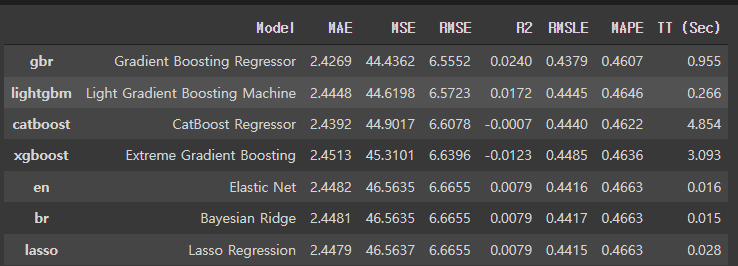

-  pycaret 을 통해 상품 카테고리 칼럼을 one-hot encoding 하지 않았을 경우보다 one-hot encoding 처리를 진행했을 때 모델의 성능이 더 우수하다는 것을 확인할 수 있었다. (RMSE 기준)

In [42]:
blended_l = blend_models(estimator_list= best_3_l, fold=5, optimize='RMSE') # 추출한 상위 3가지 모델 블랜딩
pred_holdout = predict_model(blended_l)
final_blended_model_l = finalize_model(blended_l)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.3927,39.9042,6.3170,0.3310,0.4260,0.4198
1,2.1929,23.9149,4.8903,0.1768,0.4144,0.4446
2,2.2760,30.7709,5.5472,-0.0022,0.4208,0.4288
3,2.3188,51.5215,7.1778,0.2301,0.4216,0.4332
4,2.3687,44.5179,6.6722,0.0791,0.4224,0.4370
Mean,2.3098,38.1259,6.1209,0.1629,0.4210,0.4327
SD,0.0710,9.7930,0.8128,0.1160,0.0037,0.0083


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2.2723,34.8495,5.9033,0.1825,0.4218,0.4336


- 단일 모델을 사용했을 때보다 상위 모델 3개를 블랜딩해서 사용했을 때의 RMSE가 더 낮은 것으로 확인된다. 

- 그러나 해당 경우에는 하이퍼 파라미터 튜닝이 어렵기 때문에 pycaret 으로 확인했을 때 우수한 성능을 보인 lightGBM 모델을 사용하기로 결정하였다.

## 2) lightGBM 초기 모델

LightGBM은 의사 결정 트리를 결합하기 위해 부스팅 기술을 사용하는 앙상블 방법이다.

In [43]:
# 학습, 검증 데이터 분할 
from sklearn.model_selection import train_test_split
raw_x=data[feature]
raw_y=data[['INVC_CONT']]

train_x, test_x, train_y, test_y = train_test_split(raw_x, raw_y, test_size=0.2, random_state=42)

# LightGBM에 맞는 데이터 세트 포맷으로 변환
train_ds = lgb.Dataset(train_x, label = train_y) 
test_ds = lgb.Dataset(test_x, label = test_y) 

print(train_y.max())
print(test_y.max())

INVC_CONT    413
dtype: int64
INVC_CONT    179
dtype: int64


In [44]:
# 각 데이터 개수 확인
print("train_x:",len(train_x))
print("train_y:",len(train_y))
print("test_x:",len(test_x))
print("test_y:",len(test_y))

train_x: 25347
train_y: 25347
test_x: 6337
test_y: 6337


lightGBM 관련 파라미터는 여러개가 있다.

우선 초기 모델은 다음과 같다.

In [47]:
# 초기 모델 파라미터 지정
params_1 = { 
          'learning_rate': 0.1, 
          'max_depth': 5, 
          'boosting': 'gbdt', # traditional gradient boosting decision tree
          'objective': 'regression', 
          'metric': 'rmse',
          'is_training_metric': True, 
         }

model_1 = lgb.train(params_1, 
                    train_ds, 
                    num_boost_round=500, # 부스팅 수
                    valid_sets=[train_ds, test_ds ],
                    early_stopping_rounds=100, # 조기종료 설정
                    verbose_eval=1)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 25347, number of used features: 316
[LightGBM] [Info] Start training from score 4.880972
[Ligh

In [48]:
pred_1=model_1.predict(test_x)

# rmes 식 지정
from sklearn.metrics import mean_squared_error
import numpy as np

def rmse(y_pred, y_test):
    return np.sqrt(mean_squared_error(y_test, y_pred))

rmse(test_y, pred_1)

5.858688358329336

## 3) 하이퍼 파라미터 조정

lightGBM 에서 조정할 수 있는 하이퍼 파라미터는 다음과 같다.

**<중요 파라미터>**

- learning_rate: 중요한 매개변수인 학습률은 일반적으로 학습률이 낮을수록 더 좋지만 모델 학습 속도가 느려진다.learning_rate는 낮추고 num_estimators는 크게 하여 최상의 결과가 나올 수 았다.

- min_data_in_leaf : 과적 합을 줄이는 방법으로 모델이 너무 구체적이되지 않도록 각 리프에 지정된 수의 관측치가 있어야 한다.

- min_child_samples : 파라미터는 최종 결정 클래스인 Leaf Node가 되기 위해서 최소한으로 필요한 데이터 개체의 수를 의미하며, 과적합을 제어하는 파라미터이다. 이 파라미터의 최적값은 훈련 데이터의 개수와 num_leaves에 의해 결정된다. 너무 큰 숫자로 설정하면 under-fitting이 일어날 수 있으며, 아주 큰 데이터셋이라면 적어도 수백~수천 정도로 가정하는 것이 편리하다.

- max_depth: 개별 트리의 복잡성은 과적 합의 결정 요인일 수 있기에 지정할 수 있다. 트리의 최대 깊이를 지정한다.

- num_leaves: 트리가 가질 수있는 최대 리프 수를 제한한다. LightGBM은 잎 모양의 나무 성장을 조정하므로이 max_depth와 함께 조정하는 것이 중요하다. 과적합을 방지하기 위해 num_leaves는 2^(max_depth)보다 작아야 한다.

- sub_sample : 과적합을 제어하기 위해 데이터를 샘플링하는 비율을 의미한다.

- feature_fraction : 모델이 너무 구체적이지 않도록 방지하며 각 반복에서 무작위로 선택되는 특성의 비율을 나타낸다.

< 보조 파라미터>

- Bagging_fraction: 무작위로 선택된 행 샘플을 각 반복에서 사용할 수 있다. feature_fraction과 유사하지만 행의 경우이다. 

- bagging_freq : 선택한 행을 업데이트하기위한 반복 빈도를 지정한다.

- colsample_bytree : 개별 트리를 학습할 때마다 무작위로 선택하는 피쳐의 비율을 제어한다. 

- reg_alpha : L1 규제를, 

- reg_lambda: L2 규제를 의미한다. 이들은 과적합을 제어하기에 좋은 옵션들이다.


- LightGBM은 L1 및 L2 정규화를 모두 지원한다.

이번에는 GridSearchCV 를 사용해서 구해보겠다. 



---




**<lightGBM 모델 디폴트 설정>**

def def __init__(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, importance_type='split', **kwargs)
LightGBM classifier.

In [49]:
# 1) 직접 파라미터 조정 진행
params_2 = { 
          'learning_rate': 0.6, # 변경
          'max_depth': 5, 
          'boosting': 'gbdt', # traditional gradient boosting decision tree
          'objective': 'regression', 
          'metric': 'rmse',
          'is_training_metric': True,
          #'min_data_in_leaf':600,
          #'feature_fraction':0.3,
          #'bagging_fraction':0.8,
          #'bagging_freq':2,
          #'max_depth':5,
          #'num_leaves':8,
         }


model_2 = lgb.train(params_2, 
                    train_ds, 
                    num_boost_round=500, # 부스팅 수
                    valid_sets=[train_ds, test_ds ],
                    early_stopping_rounds=100, # 조기종료 설정
                    verbose_eval=100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 25347, number of used features: 316
[LightGBM] [Info] Start training from score 4.880972
[Ligh

In [50]:
pred_2=model_2.predict(test_x)

# rmes 식 지정
from sklearn.metrics import mean_squared_error
import numpy as np

def rmse(y_pred, y_test):
    return np.sqrt(mean_squared_error(y_test, y_pred))

rmse(test_y, pred_2)

5.80668183414789

학습률을 조정한 결과 5.811058577878222 -> 5.80668183414789 가 조정된 것이 확인된다. 

나머지 변수들의 조합으로는 RMSE 를 더 낮추지 못하였다.

In [53]:
from sklearn.model_selection import GridSearchCV

model_3=lgb.LGBMClassifier()

# 2) GridSearchCV 사용
params_3 = { 
          'learning_rate': [0.1, 0.5], 
          'min_child_samples': [10, 30],
          'max_depth': [-1,4], 
          'boosting': ['gbdt', 'dart'],
          'n_jobs': [1],
          'reg_alpha' : [0.0, 0.1],
          'reg_lambda' : [0,0, 0.1],   
         }

grid = GridSearchCV(model_3, params_3 , verbose=200)

In [54]:
grid.fit(train_x, train_y, early_stopping_rounds=20)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] boosting=gbdt, learning_rate=0.1, max_depth=-1, min_child_samples=10, n_jobs=1, reg_alpha=0.0, reg_lambda=0 
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[CV]  boosting=gbdt, learning_rate=0.1, max_depth=-1, min_child_samples=10, n_jobs=1, reg_alpha=0.0, reg_lambda=0, score=nan, total=   0.5s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=-1, min_child_samples=10, n_jobs=1, reg_alpha=0.0, reg_lambda=0 
[CV]  boosting=gbdt, learning_rate=0.1, max_depth=-1, min_child_samples=10, n_jobs=1, reg_alpha=0.0, reg_lambda=0, score=nan, total=   0.5s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[CV] boosting=gbdt, learning_rate=0.1, max_depth=-1, min_child_samples=10, n_jobs

GridSearchCV(cv=None, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent='warn',
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'boosting': ['gbdt', 'dart'],
                         'learning

In [55]:
# 최적의 파라미터 찾기
print(grid.best_params_)
print(grid.best_score_)

{'boosting': 'dart', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_samples': 30, 'n_jobs': 1, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
0.5556081732836364


In [59]:
# GridSearchCV 사용으로 찾은 최적 파라미터
params_3 = {'boosting': 'dart', 
            'learning_rate': 0.1, 
            'max_depth': 4, 
            'min_child_samples': 30, 
            'n_jobs': 1, 
            'reg_alpha': 0.1, 
            'reg_lambda': 0.1}


model_3 = lgb.train(params_3, 
                    train_ds, 
                    num_boost_round=500, # 부스팅 수
                    valid_sets=[train_ds, test_ds ],
                    early_stopping_rounds=100, # 조기종료 설정
                    verbose_eval=100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 25347, number of used features: 316
[LightGBM] [Info] Start training from score 4.880972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [60]:
pred_3=model_3.predict(test_x)

# rmes 식 지정
from sklearn.metrics import mean_squared_error
import numpy as np

def rmse(y_pred, y_test):
    return np.sqrt(mean_squared_error(y_test, y_pred))

rmse(test_y, pred_3)

6.086349958675941

GridSearchCV 사용해서 여러 파라미터 조합을 해 보았지만 

기존에 직접 파라미터를 입력해서 조정한 모델의 성능이 가장 좋은 것으로 확인된다. (model_2)

# 결과 예측

이제 실제 데이콘에서 제공한 테스트 데이터셋의 물류예측량을 확인해보겠다. 

먼제 테스트 데이터셋을 가공한다.

In [69]:
submit=pd.concat([sample[['index']],pd.DataFrame(model_2 .predict(test_input),columns={'운송장_건수'})],axis=1)
submit

,index,운송장_건수
0,0,4.555737
1,1,4.001992
2,2,5.149797
3,3,5.207789
4,4,4.792291
...,...,...
7915,7915,4.386892
7916,7916,3.029003
7917,7917,4.012402
7918,7918,4.315659


In [71]:
# 데이터 저장
submit.to_csv(path+'submit_result.csv',index=False)

< 최종결과 >

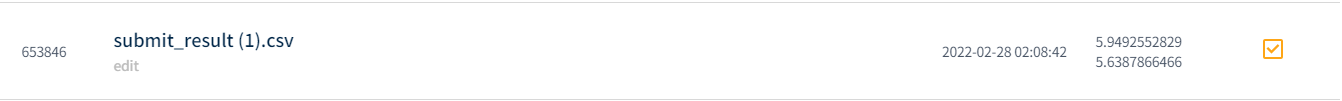

결과적으로 Dacon 사이트에서 테스트 데이터셋으로 RMSE 를 확인하였을 때  publice: 5.9492552829, private: 5.6387866466 의 성능을 보이는 것이 확인되었다.